In this week, you are required to implement a toy GATConv and SAGEConv based on document. Also, you need to implement both in PyG and DGL. In this work, you will get a further understanding of tensor-centric in PyG and graph-centric in DGL.

## DGL

In [1]:
import os

import dgl
import dgl.function as fn
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### GraphConv
Mathematically it is defined as follows:

$$
  h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ji}}h_j^{(l)}W^{(l)})
$$
where $\mathcal{N}(i)$ is the set of neighbors of node $i$, 
$c_{ji}$ is the product of the square root of node degrees
$(i.e.,  c_{ji} = \sqrt{|\mathcal{N}(j)|}\sqrt{|\mathcal{N}(i)|})$,
and $\sigma$ is an activation function.

If a weight tensor on each edge is provided, the weighted graph convolution is defined as:

$$
  h_i^{(l+1)} = \sigma(b^{(l)} + \sum_{j\in\mathcal{N}(i)}\frac{e_{ji}}{c_{ji}}h_j^{(l)}W^{(l)})
$$
where $e_{ji}$is the scalar weight on the edge from node $j$ to node $i$.
This is NOT equivalent to the weighted graph convolutional network formulation in the paper.

To customize the normalization term :$c_{ji}$, one can first set ``norm='none'`` for
the model, and send the pre-normalized :$e_{ji}$ to the forward computation. We provide
:class:`~dgl.nn.pytorch.EdgeWeightNorm` to normalize scalar edge weight following the GCN paper.

In [26]:
class DGL_GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DGL_GraphConv, self).__init__()
        self.W = nn.Parameter(torch.rand(in_channels, out_channels))
        self.b = nn.Parameter(torch.rand(out_channels))
        self.activate = nn.ReLU()

    def forward(self, g, h):
        with g.local_scope():
            # 这里的normalization用了left+right，也就是考虑了出度+入度
            norm_src = g.out_degrees().clamp(min=1).view(-1, 1)
            norm_src = torch.pow(norm_src, -0.5)

            feat_src = norm_src * h
            feat_src = torch.matmul(feat_src, self.W)
            g.srcdata["h"] = feat_src
            g.update_all(fn.u_mul_e("h", "edge_weight", "he"), fn.sum("he", "rst"))
            rst = g.dstdata["rst"]

            norm_dst = g.in_degrees().clamp(min=1).view(-1, 1)
            norm_dst = torch.pow(norm_dst, -0.5)
            rst = rst * norm_dst

            rst += self.b
            return F.relu(rst)

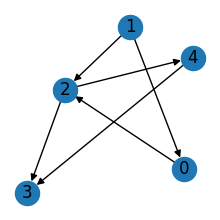

In [25]:
src = torch.tensor([0, 1, 1, 2, 2, 4])
dst = torch.tensor([2, 0, 2, 3, 4, 3])
h = torch.ones((5, 8))

g = dgl.graph((src, dst))
g.ndata["h"] = h
edge_weight = torch.ones(g.num_edges())  # 给各个边赋格权重
g.edata["edge_weight"] = edge_weight
plt.figure(figsize=(2, 2))
nx.draw(dgl.to_networkx(g), with_labels=True)

In [32]:
in_channels = h.shape[1]
out_channels = in_channels  # *2
dgl_graphConv = DGL_GraphConv(in_channels, out_channels)

In [33]:
dgl_graphConv(g, h)

tensor([[2.1296, 4.5994, 3.6825, 3.6156, 2.8758, 3.3465, 2.9255, 4.2599],
        [0.2342, 0.9638, 0.6446, 0.8826, 0.4221, 0.4741, 0.7989, 0.4236],
        [3.4698, 7.1701, 5.8306, 5.5481, 4.6109, 5.3777, 4.4293, 6.9727],
        [3.4698, 7.1701, 5.8306, 5.5481, 4.6109, 5.3777, 4.4293, 6.9727],
        [2.1296, 4.5994, 3.6825, 3.6156, 2.8758, 3.3465, 2.9255, 4.2599]],
       grad_fn=<ReluBackward0>)

### GATConv
Graph attention layer from Graph Attention Network
$$h_i^{(l+1)} = \sum_{j\in \mathcal{N}(i)} \alpha_{i,j} W^{(l)} h_j^{(l)}$$

where $\alpha_{ij}$ is the attention score bewteen node $i$ and
node $j$:

$$
\begin{align}\begin{aligned}\alpha_{ij}^{l} &= \mathrm{softmax_i} (e_{ij}^{l})\\e_{ij}^{l} &= 
\mathrm{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)\end{aligned}\end{align}
$$

这里的 $softmax_i$ 是对节点$i$的多个边进行归一化，不考虑其他边

In [17]:
from dgl.nn.functional import edge_softmax


class DGL_GATConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DGL_GATConv, self).__init__()
        # self.W=nn.Parameter(torch.rand(in_channels,out_channels))
        # self.a=nn.Parameter(torch.rand(2*in_channels,1))
        self.W = nn.Linear(in_channels, out_channels, bias=False)
        self.a_fc = nn.Linear(out_channels * 2, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU()

    def edge_attention(self, edges):
        hiW = self.W(edges.dst["h"])
        hjW = self.W(edges.src["h"])
        h_cat = torch.cat([hiW, hjW], dim=1)
        e = self.leakyrelu(self.a_fc(h_cat))
        return {"e": e}

    def forward(self, g: dgl.graph, h, get_attention=False):
        with g.local_scope():
            g.apply_edges(self.edge_attention)
            e = g.edata["e"]
            alpha = edge_softmax(g, e)
            g.edata["alpha"] = alpha
            hW = self.W(h)

            g.ndata["hW"] = hW
            g.update_all(fn.u_mul_e("hW", "alpha", "m"), fn.sum("m", "hN"))
            hN = g.ndata["hN"]

            if get_attention:
                return hN, alpha
            else:
                return hN

In [44]:
src = torch.tensor([0, 1, 1, 2, 2, 4])
dst = torch.tensor([2, 0, 2, 3, 4, 3])
h = torch.ones((5, 8))

g = dgl.graph((src, dst))
g = dgl.add_self_loop(g)
g.ndata["h"] = h
g

Graph(num_nodes=5, num_edges=11,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={})

In [45]:
myGATConv = DGL_GATConv(8, 4)
torch.nn.init.ones_(myGATConv.W.weight)
torch.nn.init.ones_(myGATConv.a_fc.weight)

print(myGATConv.W.weight)
print(myGATConv.a_fc.weight)

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)


In [47]:
myGATConv(g, h, get_attention=True)

(tensor([[8., 8., 8., 8.],
         [8., 8., 8., 8.],
         [8., 8., 8., 8.],
         [8., 8., 8., 8.],
         [8., 8., 8., 8.]], grad_fn=<GSpMMBackward>),
 tensor([[0.3333],
         [0.5000],
         [0.3333],
         [0.3333],
         [0.5000],
         [0.3333],
         [0.5000],
         [1.0000],
         [0.3333],
         [0.3333],
         [0.5000]], grad_fn=<EdgeSoftmaxBackward>))

In [27]:
# Case 1: Homogeneous graph
from dgl.nn import GATConv

g = dgl.graph(([0, 1, 2, 3, 2, 5], [1, 2, 3, 4, 0, 3]))
g = dgl.add_self_loop(g)

In [42]:
src = torch.tensor([0, 1, 1, 2, 2, 4])
dst = torch.tensor([2, 0, 2, 3, 4, 3])
h = torch.ones((5, 8))

g = dgl.graph((src, dst))
g = dgl.add_self_loop(g)
g.ndata["h"] = h
g

Graph(num_nodes=5, num_edges=11,
      ndata_schemes={'h': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={})

In [48]:
gatconv = GATConv(8, 4, num_heads=1)

torch.nn.init.ones_(gatconv.fc.weight)
torch.nn.init.ones_(gatconv.attn_l)
torch.nn.init.ones_(gatconv.attn_r)

print(gatconv.fc.weight)
print(gatconv.attn_l)
print(gatconv.attn_r)

Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True)
Parameter containing:
tensor([[[1., 1., 1., 1.]]], requires_grad=True)
Parameter containing:
tensor([[[1., 1., 1., 1.]]], requires_grad=True)


In [49]:
gatconv(g, h, get_attention=True)

(tensor([[[8., 8., 8., 8.]],
 
         [[8., 8., 8., 8.]],
 
         [[8., 8., 8., 8.]],
 
         [[8., 8., 8., 8.]],
 
         [[8., 8., 8., 8.]]], grad_fn=<AddBackward0>),
 tensor([[[0.3333]],
 
         [[0.5000]],
 
         [[0.3333]],
 
         [[0.3333]],
 
         [[0.5000]],
 
         [[0.3333]],
 
         [[0.5000]],
 
         [[1.0000]],
 
         [[0.3333]],
 
         [[0.3333]],
 
         [[0.5000]]], grad_fn=<EdgeSoftmaxBackward>))

In [51]:
# 完全相同耶
# (tensor([[8., 8., 8., 8.],
#          [8., 8., 8., 8.],
#          [8., 8., 8., 8.],
#          [8., 8., 8., 8.],
#          [8., 8., 8., 8.]], grad_fn=<GSpMMBackward>),
#  tensor([[0.3333],
#          [0.5000],
#          [0.3333],
#          [0.3333],
#          [0.5000],
#          [0.3333],
#          [0.5000],
#          [1.0000],
#          [0.3333],
#          [0.3333],
#          [0.5000]], grad_fn=<EdgeSoftmaxBackward>))

### SAGEConv
$$
\begin{align}\begin{aligned}h_{\mathcal{N}(i)}^{(l+1)} &= \mathrm{aggregate}
\left(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)\\h_{i}^{(l+1)} &= \sigma \left(W \cdot \mathrm{concat}
(h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right)\\h_{i}^{(l+1)} &= \mathrm{norm}(h_{i}^{(l+1)})\end{aligned}\end{align}
$$
If a weight tensor on each edge is provided, the aggregation becomes:
$$
h_{\mathcal{N}(i)}^{(l+1)} = \mathrm{aggregate}
\left(\{e_{ji} h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)
$$
where $e_{ji}$ is the scalar weight on the edge from node $j$ to node $i$.
    Please make sure that $e_{ji}$ is broadcastable with $h_j^{l}$.





In [ ]:
class DGL_SAGEConv(nn.Module):
    def __init__(self, in_channel, out_channel):
        pass

    def forward(self, g, h):
        pass

If you want to check your answer, you can run the following code.

In [ ]:
edge_index = torch.tensor([[0, 1, 1, 2, 2, 4], [2, 0, 2, 3, 4, 3]])
x = torch.ones((5, 8))
conv = PyG_GATConv(8, 4)
output = conv(x, edge_index)
print(output)
conv = PyG_SAGEConv(8, 4)
output = conv(x, edge_index)
print(output)

src = torch.tensor([0, 1, 1, 2, 2, 4])
dst = torch.tensor([2, 0, 2, 3, 4, 3])
h = torch.ones((5, 8))
g = dgl.graph((src, dst))
conv = DGL_GATConv(8, 4)
output = conv(g, h)
print(output)
conv = DGL_SAGEConv(8, 4)
output = conv(g, h)
print(output)